In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
%matplotlib inline

pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

In [2]:
df = pd.read_csv('../US_births.csv', low_memory=False)
df = df.sample(n=100_000, random_state=42)
df.shape

(100000, 55)

In [3]:
def drop_rows(df):
    df.drop(df[df['DBWT'].eq(9999)].index, inplace=True)
#     df['DBWT'] = np.where(df['DBWT'].eq(9999), df[df['DBWT'].lt(9999)]['DBWT'].mean(), df['DBWT'])
    
    df.drop(df[df['BMI'].eq(99.9)].index, inplace=True)
    df.drop(df[df['DBWT'].eq(9999)].index, inplace=True)
    df.drop(df[df['WTGAIN'].eq(99)].index, inplace=True)
    df.drop(df[df['PWgt_R'].eq(999)].index, inplace=True)
#     df.drop(df[df['FAGECOMB'].eq(99)].index, inplace=True)
    df.drop(df[df['DLMP_MM'].eq(99)].index, inplace=True)
    df.drop(df[df['DLMP_YY'].eq(9999)].index, inplace=True)
    return df


In [4]:
df = drop_rows(df)
df.shape

(92717, 55)

In [6]:
def feature_engineer(df):
    df['binary_sex'] = np.where(df['SEX'] == 'M', 1, 0)
    df['first_birth'] = np.where(df['ILLB_R'].eq(888), 1, 0)

    df['binary_sex'] = np.where(df['SEX'] == 'M', 1, 0)
    df['first_birth'] = np.where(df['ILLB_R'].eq(888), 1, 0)

    
    conditions = [df['CIG_0'].eq(0),
                  df['CIG_0'].eq(99)]
    choices = ['None',
               'Unknown']
    df['smoked'] = np.select(conditions, choices, 'Daily')

    
    conditions = [df['PRIORDEAD'].eq(0),
                  df['PRIORDEAD'].eq(99)]
    choices = ['None',
               'Unknown']
    df['PRIORDEAD_cat'] = np.select(conditions, choices, 'Yes')

    
    conditions = [df['PRIORTERM'].eq(0),
                  df['PRIORTERM'].eq(99)]
    choices = ['None',
               'Unknown']
    df['PRIORTERM_cat'] = np.select(conditions, choices, 'Yes')

    
    conditions = [df['PRIORLIVE'].eq(0),
                  df['PRIORLIVE'].eq(99)]
    choices = ['None',
               'Unknown']
    df['PRIORLIVE_cat'] = np.select(conditions, choices, 'Yes')

    
    conditions = [(df['DOB_MM'] > df['DLMP_MM']) & (2018 == df['DLMP_YY']),
                  (df['DOB_MM'] > df['DLMP_MM']) & (2018 > df['DLMP_YY']),
                  (df['DOB_MM'] < df['DLMP_MM']) & (2018 > df['DLMP_YY'])]
    choices = [df['DOB_MM'] - df['DLMP_MM'],
               ((df['DOB_YY'] - df['DLMP_YY'])* 12) + df['DOB_MM'] - df['DLMP_MM'],
               ((df['DOB_YY'] - df['DLMP_YY'])* 12) - df['DLMP_MM'] + df['DOB_MM']]
    df['pregnancy_length'] = np.select(conditions,choices, 12)


    df['MAGER_cat'] = np.where(df['MAGER'].lt(18),'Minor','Adult')

    
    condition =[df['pregnancy_length'].eq(9),
                df['pregnancy_length'].eq(8),
                df['pregnancy_length'].eq(10),
                df['pregnancy_length'].lt(7)]
    choices = ['9',
              '8',
               '10',
               'Early']
    df['pregnancy_length_cat'] = np.select(condition,choices, 'Late')

    
    df['BMI_log'] = np.log(df['BMI'])
    df['first_birth'] = np.where(df['ILLB_R'].eq(888), 1, 0)
    df['plural_delivery'] = np.where(df['ILLB_R'].lt(4), 'Yes', 'No')
    df['first_pregnancy'] = np.where(df['ILP_R'].eq(888), 1, 0)
    df['first_natal'] = np.where(df['ILOP_R'].eq(888),1, 0)
    df['PRECARE'] = np.where(df['PRECARE'].eq(99), 0, df['PRECARE'])
    df['PREVIS'] = np.where(df['PREVIS'].eq(99), 0, df['PREVIS'])
    df['35AGE_older'] = np.where(df['MAGER'].gt(34), 1, 0)

    df['pregnancy_length_WTGAIN'] = df['pregnancy_length']/df['PWgt_R']
    df['MOM_weight'] = (df['M_Ht_In']**2)*df['BMI']/704
    df['WTGAIN_div_MOM_weight'] = df['WTGAIN']/df['MOM_weight']
    df['WTGAIN_div_length'] = df['WTGAIN'] / df['pregnancy_length']
    df['Weight_before'] = df['MOM_weight'] - df['WTGAIN']
    df['WT_percent_gain'] = df['WTGAIN'] / df['PWgt_R']
    return df


In [7]:
df = feature_engineer(df)
df.shape

(92717, 75)

In [26]:
df['smoked'].value_counts()

None       84817
Daily       7588
Unknown      312
Name: smoked, dtype: int64

In [8]:
X = df[['ATTEND','BFACIL', 'smoked', 'DOB_MM', 'DMAR','FHISPX','FEDUC', 'FRACE6', 'first_birth', 'plural_delivery', 'first_pregnancy', 'first_natal',
        'IP_GON', 'LD_INDL', 'MAGER', '35AGE_older','MAR_IMP', 'MBSTATE_REC', 'MEDUC', 'MHISPX', 'MRAVE6', 'MTRAN', 'pregnancy_length', 'WTGAIN_div_MOM_weight','WTGAIN_div_length',
        'NO_INFEC','NO_MMORB','NO_RISKS','PAY', 'PAY_REC','PRECARE','PREVIS', 'PRIORDEAD_cat', 'PRIORLIVE_cat', 'PRIORTERM_cat', 'PWgt_R', 'BMI_log','M_Ht_In', 'MOM_weight',
        'RDMETH_REC', 'RESTATUS', 'RF_CESAR', 'SEX', 'WTGAIN','WT_percent_gain','MAGER_cat','pregnancy_length_cat','BMI'
]]
_X = pd.get_dummies(X, columns=['ATTEND', 'BFACIL','smoked', 'DOB_MM','DMAR','FHISPX','FEDUC','FRACE6', 'plural_delivery',
                                'IP_GON','LD_INDL', '35AGE_older','MAR_IMP', 'MBSTATE_REC', 'MEDUC', 'MHISPX', 'MRAVE6', 'MTRAN',
                                'NO_INFEC','NO_MMORB','NO_RISKS', 'PAY', 'PAY_REC','PRIORDEAD_cat', 'PRIORLIVE_cat','PRIORTERM_cat',
                                'RDMETH_REC', 'RESTATUS', 'RF_CESAR', 'SEX','MAGER_cat','pregnancy_length_cat'])
y = df['DBWT']

In [9]:
def feat_eng_dummy(_X):
    _X['MAGER_smoked_Daily'] = _X['MAGER'] * _X['smoked_Daily']
    _X['NO_RISKS_1_length'] = _X['NO_RISKS_1'] * _X['pregnancy_length']
    _X['RDMETH_REC_3_length'] = _X['RDMETH_REC_3'] * _X['pregnancy_length']
    _X['RDMETH_REC_1_length'] = _X['RDMETH_REC_1'] * _X['pregnancy_length']
    _X['ATTEND_1_length'] = _X['pregnancy_length'] * _X['ATTEND_1']
    _X['MRAVE6_1_FRACE6_1'] = _X['MRAVE6_1'] * _X['FRACE6_1']
    _X['BFACIL_1_length'] = _X['pregnancy_length'] * _X['BFACIL_1']
    _X['BMI_log_length'] = _X['BMI_log'] * _X['pregnancy_length']
    _X['M_Ht_In_length'] = _X['DMAR_1'] * _X['pregnancy_length']
    _X['LD_INDL_N_length'] = _X['LD_INDL_N'] * _X['pregnancy_length']
    _X['MTRAN_Y_length'] = _X['MTRAN_Y'] * _X['pregnancy_length']
    _X['PRECARE_length'] = _X['PRECARE'] * _X['pregnancy_length']
    _X['PREVIS_length'] = _X['PREVIS'] * _X['pregnancy_length']
    _X['MOM_weight_length'] = _X['MOM_weight'] * _X['pregnancy_length']

    _X['RDMETH_REC_3_pregnancy_length_cat_9'] = _X['RDMETH_REC_3'] * _X['pregnancy_length_cat_9']
    _X['RF_CESAR_Y_pregnancy_length_cat_9'] = _X['RF_CESAR_Y'] * _X['pregnancy_length_cat_9']
    return _X

In [10]:
_X = feat_eng_dummy(_X)
_X.shape

(92717, 183)

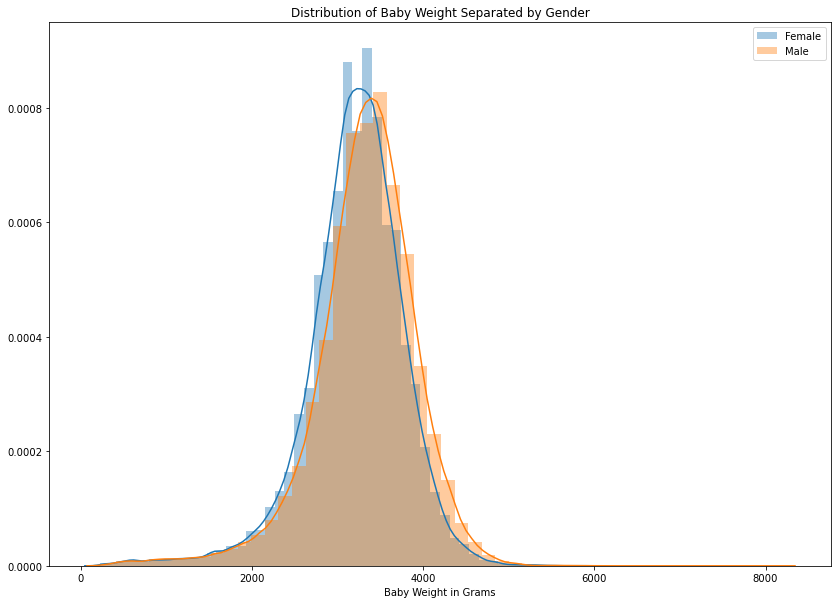

In [49]:
plt.figure(figsize=(14,10))
sns.distplot(_X[_X['SEX_M'].eq(0)]['DBWT'], label = 'Female')
sns.distplot(_X[_X['SEX_M'].eq(1)]['DBWT'], label = 'Male')
plt.title('Distribution of Baby Weight Separated by Gender')
plt.xlabel('Baby Weight in Grams')
plt.legend();

In [25]:
# null: Male Baby Weight = Female Baby Weight
# alt: Male Baby Weight != Female Baby Weight
# alpha: 0.05
stats.f_oneway(_X[_X['SEX_M'].eq(0)]['DBWT'],
              _X[_X['SEX_M'].eq(1)]['DBWT'])

F_onewayResult(statistic=970.416508622556, pvalue=6.055589984445634e-212)

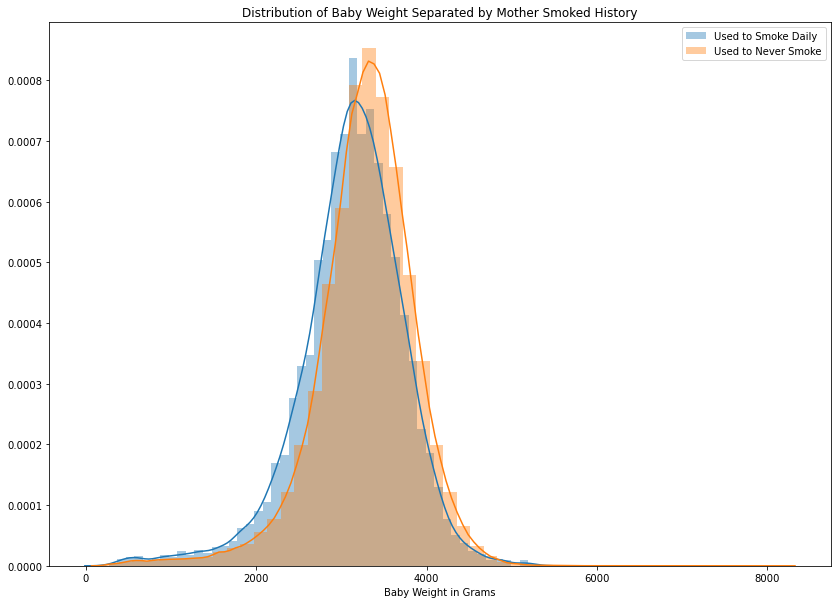

In [50]:
plt.figure(figsize=(14,10))
sns.distplot(_X[_X['smoked_Daily'].eq(1)]['DBWT'], label = 'Used to Smoke Daily')
sns.distplot(_X[_X['smoked_None'].eq(1)]['DBWT'], label = 'Used to Never Smoke')
plt.title('Distribution of Baby Weight Separated by Mother Smoked History')
plt.xlabel('Baby Weight in Grams')
plt.legend();

In [30]:
# null: Baby Weight of Moms who used to Smoke Daily = Baby Weight of Moms who never smoked
# alt: Baby Weight of Moms who used to Smoke Daily != Baby Weight of Moms who never smoked
# alpha: 0.05
stats.f_oneway(_X[_X['smoked_Daily'].eq(1)]['DBWT'],
              _X[_X['smoked_None'].eq(1)]['DBWT'])

F_onewayResult(statistic=549.710723687701, pvalue=3.2950986297023767e-121)

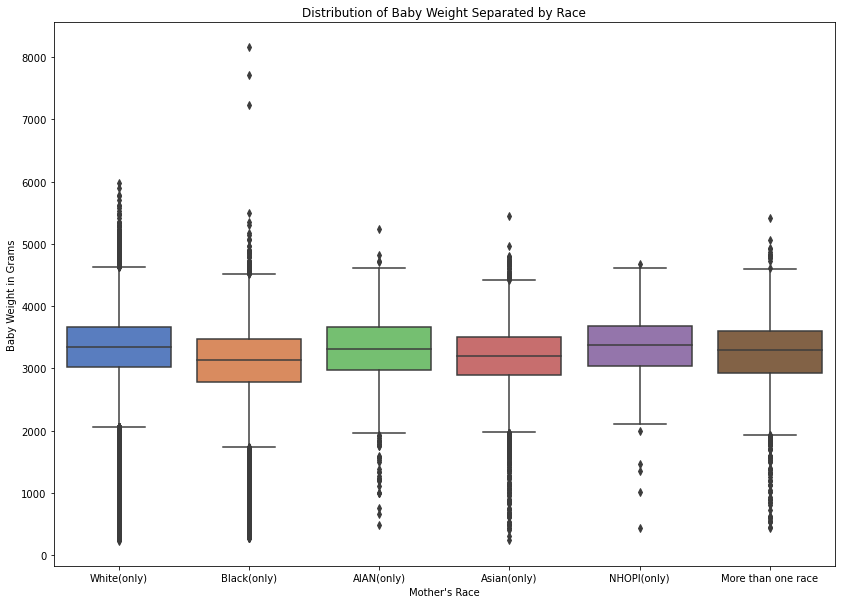

In [68]:
fig, ax = plt.subplots(figsize=(14,10))
sns.boxplot(x='MRAVE6',y='DBWT', data=df, palette='muted')
ax.set_title('Distribution of Baby Weight Separated by Race')
ax.set_xlabel('Mother\'s Race')
ax.set_ylabel('Baby Weight in Grams')
ax.set_xticklabels(['White(only)','Black(only)','AIAN(only)','Asian(only)','NHOPI(only)','More than one race']);

In [70]:
# null: Baby Weights of Moms of different Race are equal
# alt: Baby Weights of Moms of different Race are NOT equal
# alpha: 0.05
stats.f_oneway(_X[_X['MRAVE6_1'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_2'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_3'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_4'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_5'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_6'].eq(1)]['DBWT'])

F_onewayResult(statistic=461.37355669985516, pvalue=0.0)

In [84]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
_result = pairwise_tukeyhsd(df['DBWT'],df['MRAVE6'])
_result._results_table

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-241.3853,0.001,-256.4049,-226.3657,True
1,3,-49.3992,0.1355,-106.5935,7.7951,False
1,4,-147.9584,0.001,-169.6554,-126.2614,True
1,5,8.0637,0.9,-87.9473,104.0747,False
1,6,-88.2862,0.001,-122.693,-53.8795,True
2,3,191.9861,0.001,133.5227,250.4495,True
2,4,93.4269,0.001,68.5766,118.2771,True
2,5,249.4489,0.001,152.6766,346.2213,True
2,6,153.0991,0.001,116.6217,189.5765,True
3,4,-98.5592,0.001,-159.083,-38.0353,True


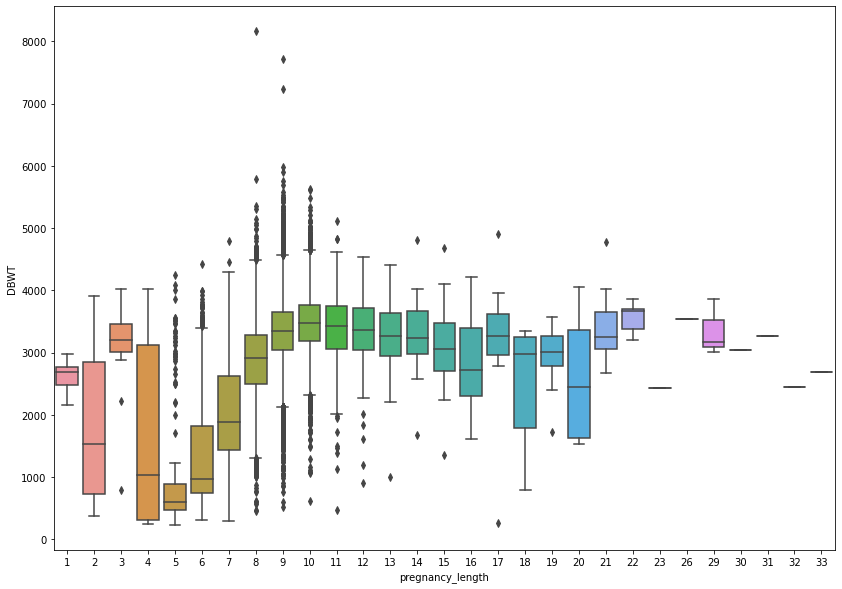

In [87]:
plt.figure(figsize=(14,10))
sns.boxplot(x='pregnancy_length',y='DBWT',data=df)

In [14]:
_X.shape

(92717, 184)

In [16]:
_X['pregnancy_length_sqrt'] =  np.sqrt(_X['pregnancy_length'])

In [17]:

_X['DBWT'] = y
from statsmodels.formula.api import ols
formula = 'DBWT~BMI_log+WTGAIN+M_Ht_In+SEX_M+BFACIL_3+ATTEND_1+DMAR_1+FRACE6_1+FEDUC_3+FRACE6_1+first_birth+plural_delivery_Yes+LD_INDL_N\
+MBSTATE_REC_1+MEDUC_6+MHISPX_2+MRAVE6_2+MRAVE6_1+MTRAN_Y+NO_RISKS_1+PAY_1+PRECARE+PREVIS+PRIORDEAD_cat_Yes+RDMETH_REC_3+RF_CESAR_Y+MAGER_smoked_Daily+pregnancy_length+MOM_weight\
+WTGAIN_div_MOM_weight+WTGAIN_div_length+NO_RISKS_1_length+RDMETH_REC_3_length+RDMETH_REC_1_length+ATTEND_1_length+BFACIL_1_length+BMI_log_length+M_Ht_In_length\
+LD_INDL_N_length+LD_INDL_N_length+MTRAN_Y_length+NO_RISKS_1_length+PREVIS_length+MOM_weight_length+pregnancy_length_cat_9+pregnancy_length_cat_8\
+pregnancy_length_cat_10+pregnancy_length_cat_Early+RDMETH_REC_3_pregnancy_length_cat_9+RF_CESAR_Y_pregnancy_length_cat_9+pregnancy_length_sqrt'
model = ols(formula=formula, data=_X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DBWT   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     1125.
Date:                Thu, 30 Jul 2020   Prob (F-statistic):               0.00
Time:                        09:23:40   Log-Likelihood:            -7.0080e+05
No. Observations:               92717   AIC:                         1.402e+06
Df Residuals:                   92668   BIC:                         1.402e+06
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                           -1.042e+04    599.799    -17.378      0.000   -1.16e+04   -9247.990
BMI_log                              1766.3061    200.297      8.818      0.000    1373.726    2158.887
WTGAIN                                -13.9550      0.912    -15.309      0.000     -15.742     -12.168
M_Ht_In                                49.5696      1.601     30.970      0.000      46.433      52.707
SEX_M                                 116.5530      3.053     38.176      0.000     110.569     122.537
BFACIL_3                              104.6320     24.408      4.287      0.000      56.792     152.472
ATTEND_1                             -179.9850     45.551     -3.951      0.000    -269.265     -90.705
DMAR_1                                -62.9353     36.113     -1.743      0.081    -133.716       7.846
FRACE6_1                               50.3441      4.225     11.917      0.000      42.064      58.624
FEDUC_3                               -11.8872      3.621     -3.283      0.001     -18.984      -4.791
first_birth                          -108.4090      3.511    -30.879      0.000    -115.290    -101.528
plural_delivery_Yes                  -687.0646     13.910    -49.393      0.000    -714.328    -659.801
LD_INDL_N                            -159.5327     43.387     -3.677      0.000    -244.571     -74.494
MBSTATE_REC_1                         -49.1492      3.942    -12.469      0.000     -56.875     -41.424
MEDUC_6                                16.8772      4.059      4.158      0.000       8.922      24.833
MHISPX_2                              -26.0620     11.300     -2.306      0.021     -48.209      -3.915
MRAVE6_2                             -108.7164      6.454    -16.844      0.000    -121.367     -96.066
MRAVE6_1                               34.9639      5.701      6.133      0.000      23.790      46.138
MTRAN_Y                              -837.8807    132.406     -6.328      0.000   -1097.395    -578.366
NO_RISKS_1                            286.3830     43.009      6.659      0.000     202.085     370.681
PAY_1                                 -23.2510      3.605     -6.450      0.000     -30.316     -16.185
PRECARE                                16.7701      1.058     15.850      0.000      14.696      18.844
PREVIS                                 24.7428      3.882      6.374      0.000      17.134      32.351
PRIORDEAD_cat_Yes                     -73.9579     14.282     -5.178      0.000    -101.951     -45.965
RDMETH_REC_3                        -1255.0055     44.773    -28.030      0.000   -1342.761   -1167.250
RF_CESAR_Y                           -141.0771     45.129     -3.126      0.002    -229.530     -52.624
MAGER_smoked_Daily                     -4.7649      0.207    -23.03